# Routing: Langgraph 와 Langfuse 로 Amazon Bedrock 시작하기

이 노트북은 [Langfuse](https://langfuse.com/) 를 사용하여 Amazonb Bedrock 의 LLM 을 사용하는 방법을 
가이드하는 노트북 입니다.

구체적으로 LangGraph 로 routing 하는 방법을 배웁니다.

### 참조
- [LangGraph: Workflows and Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#prompt-chaining)
- [Local RAG agent with LLaMA3](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag_local/)



---

## 1. 선수 사항: 
### 1.1 Langfuse 사용 환경 및 콘다 가상 환경 생성
- 아래의 설치 가이드에 따라 먼저 진행 해주세요.
    - [환경 설치 가이드: ](https://github.com/aws-samples/aws-ai-ml-workshop-kr/tree/master/genai/aws-gen-ai-kr/20_applications/19_agentic_rag)


### 1.2. Key 정보를 저장하는 env 파일 생성
-  ../../.env 파일을 생성하고 아래의 내용을 작성, 19_agentic_rag 폴더 아래에 생성 하시면 됩니다.
    ```
    LANGFUSE_SECRET_KEY=<secret key>
    LANGFUSE_PUBLIC_KEY=<public key>
    LANGFUSE_HOST=<host url>
    ```    

## 2. 환경 설정

In [14]:
%load_ext autoreload
%autoreload 2

import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)


module_path = ".."
add_python_path(module_path)

from utils.langgraph_util import ( 
    show_graph_dag,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
python path: /home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/07_start_langgraph_bedrock_langfuse already exists
sys.path:  ['/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/07_start_langgraph_bedrock_langfuse/03_langgraph', '/home/sagemaker-user/.conda/envs/langgraph/lib/python310.zip', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10/lib-dynload', '', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10/site-packages', '/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/07_start_langgraph_bedrock_langfuse']


## 3. 환경 변수 로딩
아래와 같은 환경 변수를 로딩 함.
```
LANGSMITH_TRACING=true
LANGSMITH_API_KEY=your_langsmith_api_key
OPENAI_API_KEY=your_openai_api_key
```

In [15]:
from dotenv import load_dotenv

# .env 파일에서 환경 변수 로드
load_dotenv("../../.env")



True

## 4. langfuse_handler 핸들러 작성하기

In [16]:
from langfuse.callback import CallbackHandler
import os

langfuse_handler = CallbackHandler(
    public_key=os.environ.get('LANGFUSE_PUBLIC_KEY'),
    secret_key=os.environ.get('LANGFUSE_SECRET_KEY'),
    host=os.environ.get('LANGFUSE_HOST'),
)

### langfuse endpoint 에 인증 해보기

In [17]:
# connection test
langfuse_handler.auth_check()

True

## 5. LangChain 인터페이스의 Bedrock 모델 생성
- LangChain 개발자 가이드: [ChatBedrock](https://python.langchain.com/docs/integrations/chat/bedrock/)

]

In [18]:
from langchain_aws import ChatBedrockConverse

# model_id = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"
model_id = "us.amazon.nova-pro-v1:0"

llm = ChatBedrockConverse(
    model= model_id,
    temperature=0,
    max_tokens=None,
    # other params...
)

llm

ChatBedrockConverse(client=<botocore.client.BedrockRuntime object at 0x7fd4f4132ad0>, model_id='us.amazon.nova-pro-v1:0', temperature=0.0, region_name='us-east-1', provider='amazon', supports_tool_choice_values=['auto'])

## 6. Grpah 정의 하기

In [19]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)    


### State 정의

In [20]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# State
class State(TypedDict):
    input: str
    decision: str
    output: str

### Node 및 분기  함수 정의

In [21]:
# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

In [22]:
def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

### 그래프 구조 만들기

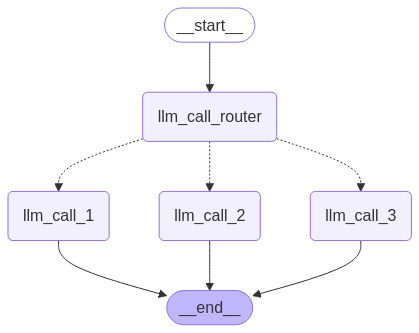

In [23]:
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))


### Graph 호출

In [11]:
# Invoke
state = router_workflow.invoke({"input": "Write me a joke about 고양이 in Korean"},
    config={
            "callbacks": [langfuse_handler],
        }
)

### 최종 State 값 보기
- 각 Node 에서 State Class 의 변수에 값을 할당함.

In [12]:
state

{'input': 'Write me a joke about 고양이 in Korean',
 'decision': 'joke',
 'output': '물론입니다! 여기 고양이에 관한 재미있는 농담이 있습니다:\n\n---\n\n오늘 고양이가 컴퓨터 앞에 앉아 있더라고요. 제가 놀라서 "고양이야, 뭐 하고 있어?"라고 물었어요. 그러자 고양이가 "컴퓨터에 대한 논문을 쓰고 있어. 제목은 \'컴퓨터는 왜 내 장난감보다 재미없을까?\'"라고 대답했어요.\n\n---\n\n고양이의 재치 있는 답변이 재미있죠?'}

### State 값 흐름에 따라 출력

In [13]:
print(state["output"])

물론입니다! 여기 고양이에 관한 재미있는 농담이 있습니다:

---

오늘 고양이가 컴퓨터 앞에 앉아 있더라고요. 제가 놀라서 "고양이야, 뭐 하고 있어?"라고 물었어요. 그러자 고양이가 "컴퓨터에 대한 논문을 쓰고 있어. 제목은 '컴퓨터는 왜 내 장난감보다 재미없을까?'"라고 대답했어요.

---

고양이의 재치 있는 답변이 재미있죠?


## 7. Langfuse Tracing Output
![router.png](img/router.png)